In [ ]:
!unzip /content/drive/MyDrive/Kaggle/Hindi/checkpoints/5foldsroberta.zip

Archive:  /content/drive/MyDrive/Kaggle/Hindi/checkpoints/5foldsroberta.zip
replace output/checkpoint-fold-0/config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
!pip install sentencepiece
!pip install transformers[sentencepiece]
!pip install transformers
#!pip install pyngrok

     |████████████████████████████████| 1.2 MB 30.6 MB/s 
     |████████████████████████████████| 3.1 MB 29.1 MB/s 
     |████████████████████████████████| 59 kB 7.1 MB/s 
     |████████████████████████████████| 3.3 MB 65.5 MB/s 
     |████████████████████████████████| 895 kB 6.8 MB/s 
     |████████████████████████████████| 596 kB 67.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.utils as utils
from transformers import AutoModel,AutoConfig,AutoTokenizer
import transformers
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
import os
import random
import warnings
warnings.filterwarnings("ignore", category=UserWarning)                                     

try:
    from apex import amp
    APEX = True
except:
    APEX = False

In [3]:
class Config:
  # random
  seed = 2021

  # preprocessing
  model_name = "deepset/xlm-roberta-large-squad2"
  model_type = 'xlm_roberta'

  # tokenize
  doc_stride=128
  max_seq_len = 384

  # model
  hidden_dropout_prob = 0.1
  initializer_range = 0.02
  hidden_size = 1024
  max_query_length=64

  # train
  n_epochs = 3
  learning_rate = 2e-5
  epsilon = 1e-8
  correct_bias = True
  weight_decay = 1e-2
  LR_schedule = 'linear-warmup'
  warm_frac = 0.2
  log_steps = 100
  upload_steps = 100
  train_batch_size = 4
  valid_batch_size = 8
  acc_gradient_steps = 8

  # cuda 
  device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
  fp16 = APEX
  fp16_opt_level = "O1"

  # log
  train_loss_path = 'drive/MyDrive/Kaggle/Hindi/logs/train_loss'
  valid_loss_path = 'drive/MyDrive/Kaggle/Hindi/logs/valid_loss'
  



In [4]:
class MODEL(nn.Module):
  def __init__(self):
    super(MODEL, self).__init__()
    config = AutoConfig.from_pretrained(Config.model_name)
    self.xlm_roberta = AutoModel.from_pretrained(Config.model_name,config)
    self.qa_outputs = nn.Linear(Config.hidden_size, 2)
    self.dropout = nn.Dropout(Config.hidden_dropout_prob)
    self._init_weights(self.qa_outputs)
      
  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=Config.initializer_range)
        if module.bias is not None:
            module.bias.data.zero_()

  def forward(
        self, 
        input
    ):
        output = self.xlm_roberta(
            **input
        )
        
        sequence_output = self.dropout(output.last_hidden_state)
        qa_logits = self.qa_outputs(sequence_output)
        
        start_logits, end_logits = qa_logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
    
        return start_logits, end_logits

In [5]:
%pdb off
def checkpoint_call(path=None,is_checkpoint=False,cuda=True):
  print(path)
  if is_checkpoint:
    model = MODEL()
    model.load_state_dict(torch.load(path))
  else:
    model = XLMROBERT()
  return model.to(Config.device) if cuda == True else model.cpu()

Automatic pdb calling has been turned OFF


In [ ]:
import re
def xxl_checkpoint_call(path):
  models = []
  for i in range(5):
    model = checkpoint_call(re.sub(r"[0-9]","{}".format(i),path),True,False)
    models.append(model)
    del model
    torch.cuda.empty_cache()
  
  return models


In [ ]:
path = "/content/output/checkpoint-fold-0/pytorch_model.bin"
models = xxl_checkpoint_call(path)


/content/output/checkpoint-fold-0/pytorch_model.bin


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/content/output/checkpoint-fold-1/pytorch_model.bin


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/content/output/checkpoint-fold-2/pytorch_model.bin


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/content/output/checkpoint-fold-3/pytorch_model.bin


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/content/output/checkpoint-fold-4/pytorch_model.bin


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for name,i in models[1].named_parameters():
  print(name,i)
  

In [ ]:
models_state = [x.state_dict() for x in models]

state_dict = {}

for name,param in models[0].state_dict().items():
  value = 0
  for i in range(5):
    value += models_state[i][name]
  state_dict[name] = value/5



In [ ]:
models[0].load_state_dict(state_dict)
c_model = MODEL()

Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for name,i in models[0].named_parameters():
  print(name,i)
  

In [ ]:
torch.save(models[0].state_dict(),"/content/drive/MyDrive/Kaggle/Hindi/checkpoints/simple_adding_model.bin")

# EDA

In [6]:
%pdb off
import seaborn as sns
from nltk.tokenize import sent_tokenize
import nltk
import matplotlib.pyplot as plt

from tqdm import tqdm
nltk.download('punkt')

Automatic pdb calling has been turned OFF
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
train = pd.read_csv("/content/drive/MyDrive/Kaggle/Hindi/input/simple_corpus.csv")
simp_train = pd.read_csv("/content/drive/MyDrive/Kaggle/Hindi/input/train.csv")
comp_train = pd.read_csv("/content/drive/MyDrive/Kaggle/Hindi/input/fusion_corpus.csv")
train.head()

,Unnamed: 0,id,context,question,answer_text,answer_start,language,kfold
0,0,903deec17,ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின...,மனித உடலில் எத்தனை எலும்புகள் உள்ளன?,206,53.0,tamil,2.0
1,1,d9841668c,காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கி...,காளிதாசன் எங்கு பிறந்தார்?,காசுமீரில்,2358.0,tamil,3.0
2,2,29d154b56,சர் அலெக்ஸாண்டர் ஃபிளெமிங் (Sir Alexander Flem...,பென்சிலின் கண்டுபிடித்தவர் யார்?,சர் அலெக்ஸாண்டர் ஃபிளெமிங்,0.0,tamil,3.0
3,3,41660850a,"குழந்தையின் அழுகையை நிறுத்தவும், தூங்க வைக்கவ...",தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பா...,தாலாட்டு,68.0,tamil,0.0
4,4,b29c82c22,சூரியக் குடும்பம் \nசூரியக் குடும்பம் (Solar S...,பூமியின் அருகில் உள்ள விண்மீன் எது?,சூரியனும்,585.0,tamil,0.0


In [ ]:
train["context"].iloc[11292]

'தஜிகிஸ்தான்(I /tɑːdʒiːkᵻstɑːn/, /tədʒiːkᵻstæn/அல்லது/tædʒiːkiːstæn/;பாரசீக:تاجيكستان Тоҷикистон[tɔd͡ʒikɪstɔn]), அலுவலககுடியரசுதஜிகிஸ்தான்(பாரசீகஇன்:جمهورى تاجيكستانதாஜிக்:Ҷумҳурии Тоҷикистон,ÇumhurijiToçikiston/JumhuriyiTojikiston;ரஷியன்: Республика Таджикистастан, Respublika Tadzhikistan), மத்திய ஆசியாவில் ஒரு மலைப்பகுதியில், நிலப்பகுதி நாடு 2013 ல் 8 மில்லியன் மக்கள், மற்றும் 143,100 KM2 (55,300 சதுர மைல்) பரப்பளவு.இது ஆப்கானிஸ்தானில் தெற்கே, உஸ்பெகிஸ்தான், மேற்கில் கிர்கிஸ்தானுக்கு வடக்கு நோக்கி, கிழக்கு நோக்கி கிழக்கு நோக்கி எல்லை.பாக்கிஸ்தான் தெற்கே உள்ளது, குறுகிய வக்கன் நடைபாதையில் பிரிக்கப்பட்டுள்ளது.தாஜிக் மக்களின் பாரம்பரியமான தாயகங்களும் இன்றைய தஜிகிஸ்தான், ஆப்கானிஸ்தான் மற்றும் உஸ்பெகிஸ்தான் ஆகியவை இதில் உள்ளன.'

In [ ]:
print(simp_train.iloc[18,:])
print(simp_train.iloc[303,:])

id                                                      5e1f9bca8
context         போர்த்துகல் (Portuguese: Portugal), என்றழைக்கப...
question                       போர்த்துகல் நாட்டின் தலைநகரம் எது?
answer_text                                               லிஸ்பன்
answer_start                                                  686
language                                                    tamil
Name: 18, dtype: object
id                                                      3885c1b15
context         போர்த்துகல் (Portuguese: Portugal), என்றழைக்கப...
question                      போர்ச்சுகல் நாட்டின் தலைநகரம் எது?
answer_text                                               லிஸ்பன்
answer_start                                                  686
language                                                    tamil
Name: 303, dtype: object


In [ ]:
idd = 0
for i in range(simp_train.shape[0]):
  for j in range(i+1,simp_train.shape[0]):
    if simp_train["context"].iloc[i] == simp_train["context"].iloc[j]:
      if simp_train["answer_text"].iloc[i] == simp_train["answer_text"].iloc[j]:
        print(simp_train["id"].iloc[i],simp_train["id"].iloc[j],\
              "||",simp_train["answer_start"].iloc[i],simp_train["answer_start"].iloc[j])
#print(simp_train["answer_text"].duplicated().sum())

5e1f9bca8 3885c1b15 || 686 686
63e0197cb 37dbb9859 || 4847 4847
e0090c270 80452bc4d || 1928 1928
2a3eaf502 1a1d3f58e || 466 466
b9abcb736 d582b302a || 12 12
b9abcb736 331f5246f || 12 12
9c3ee7a2b 234fbc88b || 336 336
d582b302a 331f5246f || 12 12
0e6ff7af5 ffda743a2 || 191 191
828426a90 b02a8d62f || 26 26
a7c7a0c97 632812604 || 50 50
2bfd1f74c 76a4006f4 || 401 401
7b6a3ba94 3b4656c2b || 480 480
7128ae116 2528af932 || 3061 3061
28045a331 21342d7f1 || 3670 3670
66abec2e4 941c8cdc3 || 546 546
bb68fa5c3 bd95d41f8 || 759 759
31232fb35 e2a2cea36 || 104 104
7dd04e907 a9c31c302 || 270 270
c937f0580 13b256056 || 167 167
56e53f485 07985440d || 170 170
9c63202f3 89d938493 || 518 518
bfe815100 6c7ed667b || 0 0
36e9fff19 c06c11c38 || 21 21
1997550b6 399028c08 || 692 692


In [ ]:
print(idd)

1373


In [ ]:
print(train[["answer_text","context","answer_start"]].duplicated().sum())
print(simp_train[["id"]].duplicated().sum())
print(simp_train[["answer_text","context","answer_start"]].duplicated().sum())
print(comp_train[["answer_text","context","answer_start"]].duplicated().sum())

101
0
24
3994


In [9]:
tokenizer = AutoTokenizer.from_pretrained(Config.model_name)


Downloading:   0%|          | 0.00/179 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/606 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
def make_examples(df):
  tokenizer = AutoTokenizer.from_pretrained(Config.model_name)

  examples = []
  # train 
  if "answer_text" in df.columns: 
    for i in tqdm(range(df.shape[0])):
      tokens_info = tokenize(tokenizer,df.iloc[i,:])
      for j in range(len(tokens_info["input_ids"])):
        example = {}
        #example["id"] = df["id"].iloc[i]
        example["context"] = df["context"].iloc[i]
        example["question"] = df["question"].iloc[i]

        example["language"] = df["language"].iloc[i]
        example["input_ids"] = tokens_info["input_ids"][j]
        example["attention_mask"] = tokens_info["attention_mask"][j]
        example["offset_mapping"] = tokens_info["offset_mapping"][j]
        example["overflow_to_sample_mapping"] = tokens_info["overflow_to_sample_mapping"][j]

        cls_index = tokens_info["input_ids"][j].index(tokenizer.cls_token_id)
        sequence_ids = tokens_info.sequence_ids(j)

        sample_index = tokens_info["overflow_to_sample_mapping"][j]

        # if len([df["answer_start"].iloc[i]) == 0:
        #   example["answer_start"] = cls_index
        #   example["answer_end"] = cls_index
        # else:
        start_char = df["answer_start"].iloc[i]
        end_char = start_char + len(df["answer_text"].iloc[i])

        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
          token_start_index += 1

        token_end_index = len(example["input_ids"]) - 1
        while sequence_ids[token_end_index] != 1:
          token_end_index -= 1

        if not (example["offset_mapping"][token_start_index][0] <= start_char and example["offset_mapping"][token_end_index][1] >= end_char):
          example["answer_start"] = cls_index
          example["answer_end"] = cls_index
        else:
          while token_start_index < len(example["offset_mapping"]) and example["offset_mapping"][token_start_index][0] <= start_char:
            token_start_index += 1
          example["answer_start"] = token_start_index - 1
          while example["offset_mapping"][token_end_index][1] >= end_char:
            token_end_index -= 1
          example["answer_end"] = token_end_index + 1

        examples.append(example)
 
  # test
  else:
     for i in tqdm(range(df.shape[0])):
      example = {}
      tokens_info = tokenize(tokenizer,df.iloc[i,:])
      for j in range(len(tokens_info["input_ids"])):
        #example["id"] = df["id"].iloc[i]
        example["context"] = df["context"].iloc[i]
        example["question"] = df["question"].iloc[i]
        example["language"] = df["language"].iloc[i]
        example["input_ids"] = tokens_info["input_ids"][j]
        example["sequence_ids"] = [1 if i == None else 0 for i in tokens_info.sequence_ids(j)]
        example["attention_mask"] = tokens_info["attention_mask"][j]
        example["offset_mapping"] = tokens_info["offset_mapping"][j]
        example["tokens"] = token_info.tokens[j]
        example["overflow_to_sample_mapping"] = tokens_info["overflow_to_sample_mapping"][j]
        examples.append(example)

  return examples

# 文本词量统计

100%|██████████| 1114/1114 [00:40<00:00, 27.68it/s]


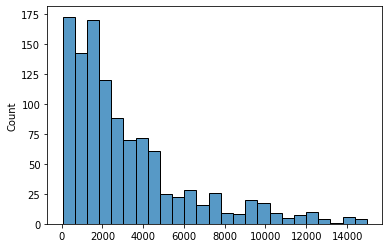

In [10]:
def tokens_dist(df,tokenizer):
  len_list = []
  for i in tqdm(range(df.shape[0])):
    #text = sent_tokenize(df["context"].iloc[i])
    tokens = tokenizer(df["context"].iloc[i],add_special_tokens=True)["input_ids"]
    len_list.append(len(tokens))
  return len_list

plt.figure()
sns.histplot(tokens_dist(simp_train,tokenizer))


100%|██████████| 11296/11296 [00:56<00:00, 198.95it/s]


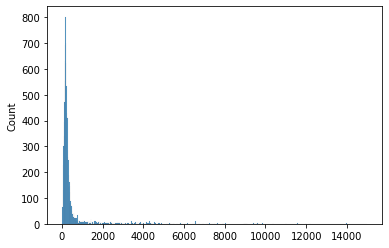

In [11]:
plt.figure()
sns.histplot(tokens_dist(train,tokenizer))

100%|██████████| 104592/104592 [02:48<00:00, 619.01it/s]


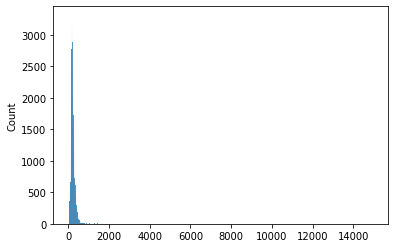

In [ ]:
plt.figure()
sns.histplot(tokens_dist(comp_train,tokenizer))

# Label比例统计

In [ ]:
def tokenize(tokenizer,df):  
  # text = df["question"].apply(lambda x: "[cls]"+x+"[sep]")+df["context"].apply(lambda x: x+"[sep]")
  tokens_info = tokenizer(df["question"],df["context"], 
                         padding='max_length',
                         truncation="only_second",
                         stride=Config.doc_stride,
                         max_length=Config.max_seq_len,
                         return_overflowing_tokens=True,
                         return_offsets_mapping=True,
                         add_special_tokens=True)
  
  return tokens_info

In [ ]:
examples = make_examples(simp_train)
label = [1 if ex["answer_start"] != 0 else 0 for ex in examples]
sns.histplot(label)

100%|██████████| 1114/1114 [00:48<00:00, 23.20it/s]


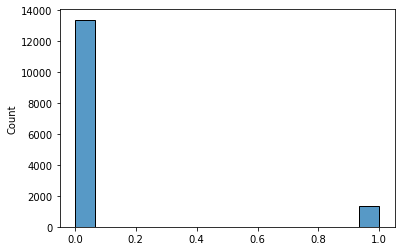

100%|██████████| 11296/11296 [01:12<00:00, 156.87it/s]


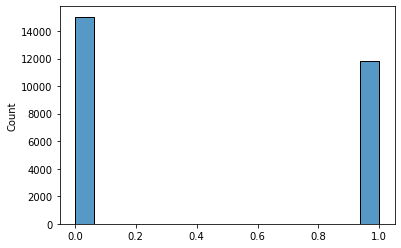

In [ ]:
examples = make_examples(train)
label = [1 if ex["answer_start"] != 0 else 0 for ex in examples]
sns.histplot(label)

In [ ]:
examples = make_examples(comp_train)
label = [1 if ex["answer_start"] != 0 else 0 for ex in examples]
sns.histplot(label)

Downloading:   0%|          | 0.00/179 [00:00<?, ?B/s]

KeyboardInterrupt: ignored

# 数据清理


In [ ]:
train_unique = train[~train[["answer_text","answer_start","context"]].duplicated()]
comp_train_unique = comp_train[~comp_train[["answer_text","answer_start","context"]].duplicated()]

In [ ]:
def remove_duplicate(train_unique):
  train_unique["context"] = train_unique["context"].apply(lambda x: " ".join(x.split()))
  train_unique["question"] = train_unique["question"].apply(lambda x: " ".join(x.split()).lstrip())
  train_unique["answer_text"] = train_unique["answer_text"].apply(lambda x: " ".join(x.split()))
  return train_unique

simp_train = remove_duplicate(simp_train)
train_unique = remove_duplicate(train_unique)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
simp_train["context"].iloc[3]


In [ ]:
print(simp_train["question"].iloc[1])


# 数据汇总

In [ ]:
comp_train.head()

,Unnamed: 0,context,question,answer_text,answer_start,language,kfold
0,0,ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின...,மனித உடலில் எத்தனை எலும்புகள் உள்ளன?,206,53.0,tamil,2.0
1,1,காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கி...,காளிதாசன் எங்கு பிறந்தார்?,காசுமீரில்,2358.0,tamil,3.0
2,2,சர் அலெக்ஸாண்டர் ஃபிளெமிங் (Sir Alexander Flem...,பென்சிலின் கண்டுபிடித்தவர் யார்?,சர் அலெக்ஸாண்டர் ஃபிளெமிங்,0.0,tamil,3.0
3,3,"குழந்தையின் அழுகையை நிறுத்தவும், தூங்க வைக்கவ...",தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பா...,தாலாட்டு,68.0,tamil,0.0
4,4,சூரியக் குடும்பம் \nசூரியக் குடும்பம் (Solar S...,பூமியின் அருகில் உள்ள விண்மீன் எது?,சூரியனும்,585.0,tamil,0.0


In [ ]:

external_data_tamil = comp_train[comp_train["language"]=="tamil"].iloc[range(0,25*100,25)]
external_data_hindi = comp_train[comp_train["language"]=="hindi"].iloc[range(0,25*2000,25)]



In [ ]:
fusion_corpis_v2 = pd.concat([train,external_data_tamil,external_data_hindi]).reset_index(drop=True)

In [ ]:
fusion_corpis_v2 = fusion_corpis_v2[~fusion_corpis_v2.duplicated()]

In [ ]:
fusion_corpis_v2["answer"].duplicated().sum()

KeyError: ignored

In [ ]:
fusion_corpus_v2 = fusion_corpis_v2.drop(columns="id").rename(columns={"Unnamed: 0":"id"})
fusion_corpus_v2.to_csv("/content/drive/MyDrive/Kaggle/Hindi/input/fusion_corpus_v2.csv")

100%|██████████| 12346/12346 [01:14<00:00, 165.08it/s]


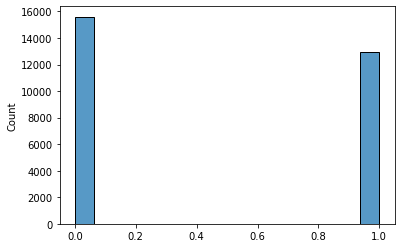

In [ ]:
examples = make_examples(fusion_corpus_v2)
label = [1 if ex["answer_start"] != 0 else 0 for ex in examples]
sns.histplot(label)